In [131]:
%load_ext autoreload
%autoreload 2
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from utils.network import VarNet2
from VN_SPIRIT.utils.dataset import *
import torch
from script.train_knee3d import *
from utils.cg_spirit_gpu import *
from utils.evaluation import esp
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
net = torch.load('exp/E2EVN_knee2d.pt')

# SPIRIT refinement

In [197]:
R = 6
mask_func = subsample.EquispacedMaskFunc(
                            center_fractions=[0.08],
                            accelerations=[R])

In [198]:
testset = Data2D('data/div_knee2d/Test', mask_func = mask_func, dset_type='knee2d')

In [199]:
ksp, mask, sens, labels = testset[12]
ksp = ksp.unsqueeze(0).cuda()
mask = mask.unsqueeze(0).cuda()
sens = sens.unsqueeze(0).cuda()

with torch.no_grad():
    out, ksp_out = net(ksp, mask, sens)

In [200]:
mask_np = mask.cpu().detach().numpy()
print('Acceleration',1/mask_np.mean())


Acceleration 6.413793103448276


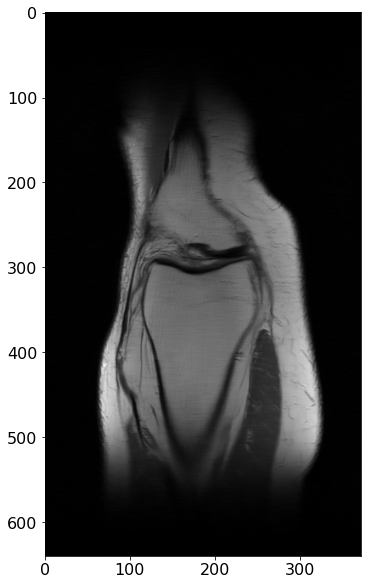

In [201]:
out_np = from_pytorch(out.cpu().detach(), iscomplex=True).squeeze()
plt.figure(figsize=(10,10))
plt.imshow(np.abs(out_np), cmap='gray')

In [202]:
res_vn_spirit, ksp_vn_spirit = SS_refine(ksp, ksp_out, sens, algorithm='spirit', kernel_size=[5,5], l2lam=0.1)

In [203]:
# Plotting resulting coil combined image
res_vn = from_pytorch(out.cpu().detach(), iscomplex=True)[0,0]
res_vn_rsc = res_vn_spirit
res_true = from_pytorch(labels.cpu().detach(), iscomplex=True)[0]

print(res_vn.shape, res_vn_rsc.shape, res_true.shape)

(640, 372) (640, 372) (640, 372)


In [204]:
def cat_resize_image(im1,im2,im3,size=[256,256]):
    im1 = sp.resize(np.abs(im1.squeeze()),size)
    im2 = sp.resize(np.abs(im2.squeeze()),size)
    im3 = sp.resize(np.abs(im3.squeeze()),size)
    full_cat = np.concatenate((im1, im2, im3), axis=1)
    return full_cat

In [205]:
res_full = cat_resize_image(res_vn, res_vn_rsc, res_true, size=[256,256])
res_mag = cat_resize_image(res_vn, res_vn_rsc, res_true, size=[128,128])
true_mag = cat_resize_image(res_true, res_true, res_true, size=[128,128])
err_mag = np.abs(res_mag - true_mag) * 5

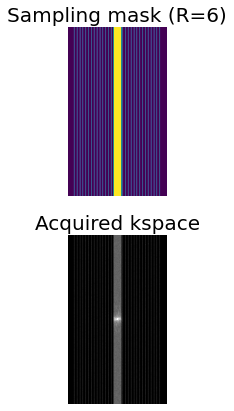

In [206]:
ksp_np = np.abs(from_pytorch(ksp.cpu().detach(), iscomplex=True)[0,0]) ** 0.2
mask_np = np.abs(ksp_np) > 0
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,6))
ax1.imshow(mask_np.squeeze())
ax1.axis('off')
title_name = 'Sampling mask (R={})'.format(R)
ax1.set_title(title_name, {'fontsize':20})
ax2.imshow(ksp_np.squeeze(), cmap='gray', vmax=1)
ax2.axis('off')
ax2.set_title('Acquired kspace', {'fontsize':20})

fig.tight_layout()

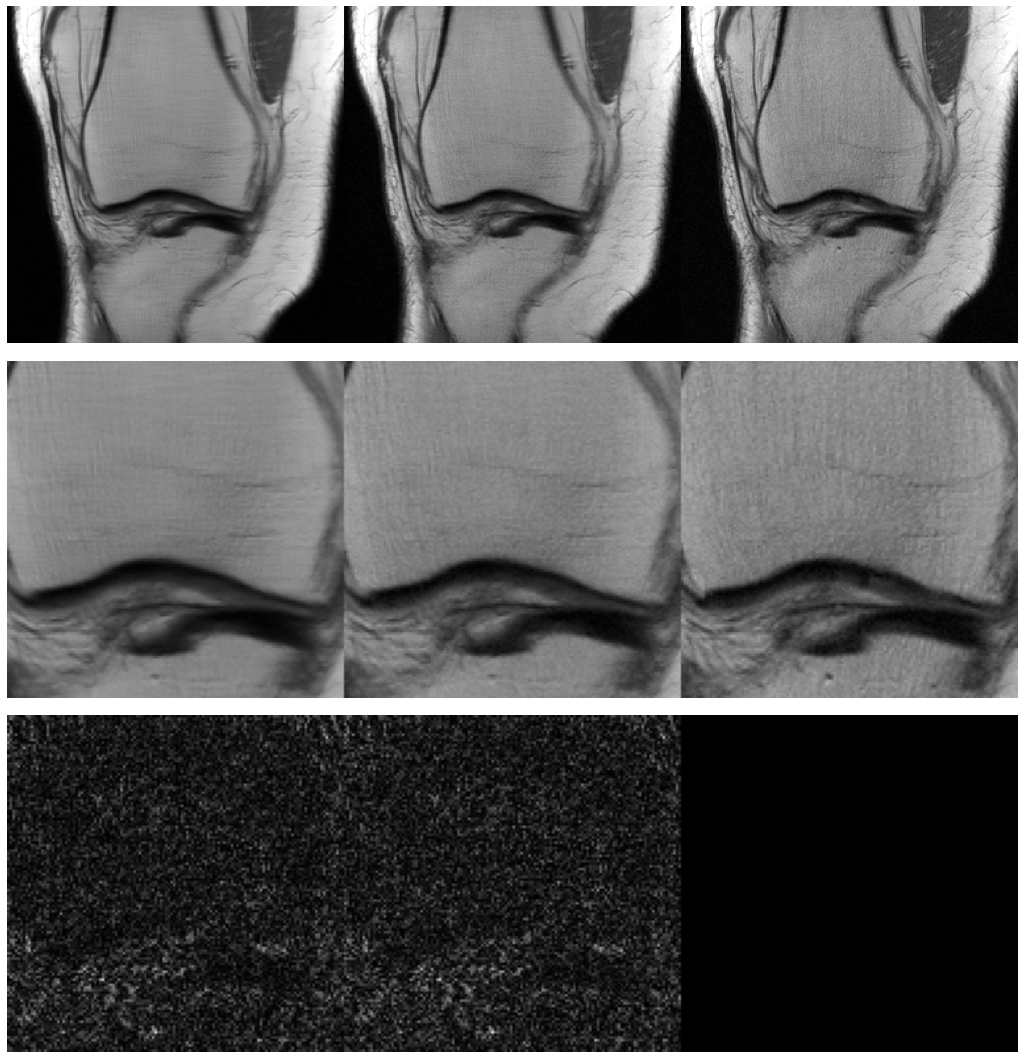

In [207]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,15))
ax1.imshow(res_full[::-1],cmap='gray',vmax=0.5)
ax1.axis('off')

ax2.imshow(res_mag[::-1],cmap='gray',vmax=0.5)
ax2.axis('off')

ax3.imshow(err_mag[::-1],cmap='gray',vmax=0.5)
ax3.axis('off')

fig.tight_layout()


/home/gridsan/chanyeol/Kanghyun/VN_SPIRIT/VN_SPIRIT/utils/evaluation.py:57: RuntimeWarning: invalid value encountered in sqrt
  err_fraction = np.real(np.sqrt(err_plot/true_plot))


Text(0.5, 0, 'Spatial Frequency (Nyquist units)')

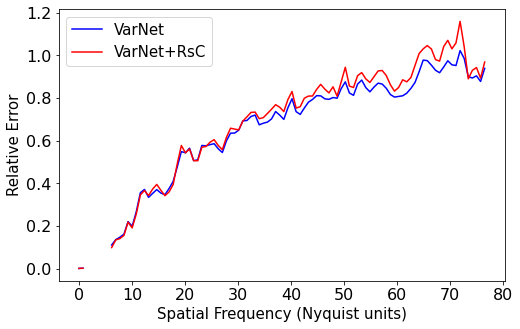

In [208]:
res_vn_center = np.abs(sp.resize(res_vn,[128,128]))
res_vn_rsc_center = np.abs(sp.resize(res_vn_rsc,[128,128]))
res_true_center = np.abs(sp.resize(res_true,[128,128]))

xi, esp_vn = esp(res_vn_center, res_true_center,1)
xi, esp_vn_spirit = esp(res_vn_rsc_center, res_true_center,1)

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8,5))
plt.plot(xi,esp_vn,'b',xi,esp_vn_spirit,'r')
plt.legend(['VarNet','VarNet+RsC'],fontsize=15)
plt.ylabel('Relative Error',fontsize=15)
plt.xlabel('Spatial Frequency (Nyquist units)',fontsize=15)